# Machine Learning Final Project

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from itertools import product


## 資料視覺化

- data

In [25]:
data = pd.read_csv(r"C:\Users\chewei\Documents\python-practice\machine learning\final project\loan.csv")
random_state = 1117

data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,0,credit_card,0.1197,481.40,11.775290,10.85,682,5071.000000,966,13.1,5,0,0,0
1,1,all_other,0.0907,238.75,11.002100,4.86,752,7626.958333,8575,25.0,1,0,0,0
2,1,debt_consolidation,0.1222,148.28,11.835009,19.00,677,6059.958333,27587,74.8,1,1,0,0
3,1,all_other,0.0774,156.10,10.803649,4.71,797,4200.041667,1299,4.2,2,0,0,0
4,0,major_purchase,0.1253,267.73,10.819778,21.29,697,3060.041667,34938,59.6,4,1,0,0


In [69]:
data.info()

# we need to convert the data type of the 'purpose' feature.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9478 entries, 0 to 9477
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9478 non-null   int64  
 1   purpose            9478 non-null   object 
 2   int.rate           9478 non-null   float64
 3   installment        9478 non-null   float64
 4   log.annual.inc     9478 non-null   float64
 5   dti                9478 non-null   float64
 6   fico               9478 non-null   int64  
 7   days.with.cr.line  9478 non-null   float64
 8   revol.bal          9478 non-null   int64  
 9   revol.util         9478 non-null   float64
 10  inq.last.6mths     9478 non-null   int64  
 11  delinq.2yrs        9478 non-null   int64  
 12  pub.rec            9478 non-null   int64  
 13  not.fully.paid     9478 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


- 轉換 purpose 的型態方法：
1. Label Encoding
2. Dummy Variables (One-Hot Encoding)

{'all_other': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'major_purchase': 5, 'small_business': 6}


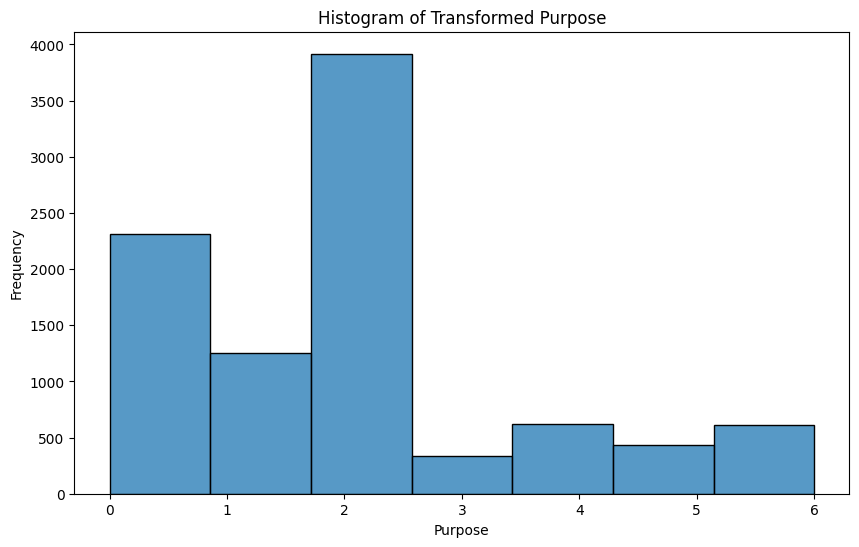

In [26]:
def Purpose_transformation(data, method):
    '''將 purpose 的型態轉換'''
    if method == 'label':
        label_encoder = LabelEncoder()
        data['purpose'] = label_encoder.fit_transform(data['purpose'])
        labelMapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    elif method in ['dummy', 'one_hot']:
        data = pd.get_dummies(data=data, columns=['purpose'], drop_first=True)
        data[dummyVars] = data[dummyVars].astype(int)
        data = data[vars]
    else:    
        raise ValueError("Method must be either 'label' or 'one_hot'")
    
    return data, labelMapping 

data, labelMapping  = Purpose_transformation(data, 'label')

plt.figure(figsize=(10, 6))
sns.histplot(data['purpose'], kde=False, bins=len(data['purpose'].unique()))
plt.title('Histogram of Transformed Purpose')
plt.xlabel('Purpose')
plt.ylabel('Frequency')

print(labelMapping)
plt.show()

- 檢查是否有缺失值與 data 是否有重複
    - 結論：無缺失值與重複的 data

In [71]:
print(data.isnull().sum())
print('duplicate: ', data.duplicated().sum())

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64
duplicate:  0


- 查看各變數的型態

int.rate              0.164135
installment           0.910142
log.annual.inc        0.033303
dti                   0.023261
fico                  0.469720
days.with.cr.line     1.156222
revol.bal            11.213374
revol.util            0.062470
dtype: float64


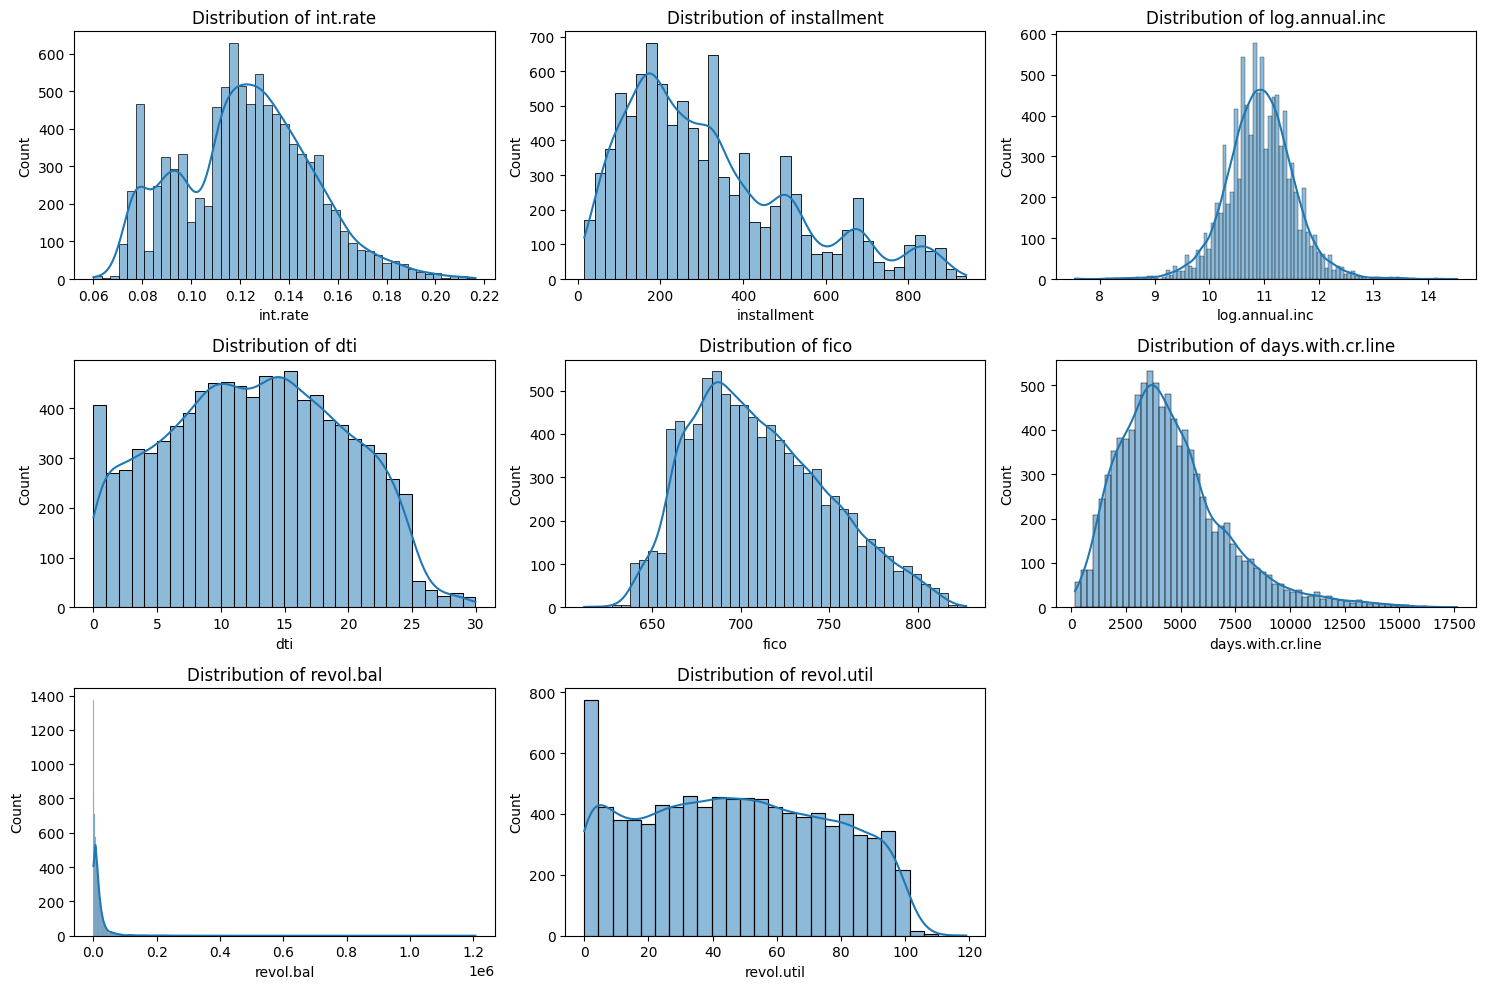

In [72]:
skewColumns = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
skewness = data[skewColumns].skew()
print(skewness)



plt.figure(figsize=(15, 10))
for i, column in enumerate(skewColumns):
    plt.subplot((len(skewColumns) + 2) // 3, 3, i + 1)  
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

Unique values in credit.policy : [0, 1]
Unique values in purpose : [0, 1, 2, 3, 4, 5, 6]
Unique values in inq.last.6mths : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 27, 28, 31, 32, 33]
Unique values in delinq.2yrs : [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13]
Unique values in pub.rec : [0, 1, 2, 3, 4, 5]
Unique values in not.fully.paid : [0, 1]


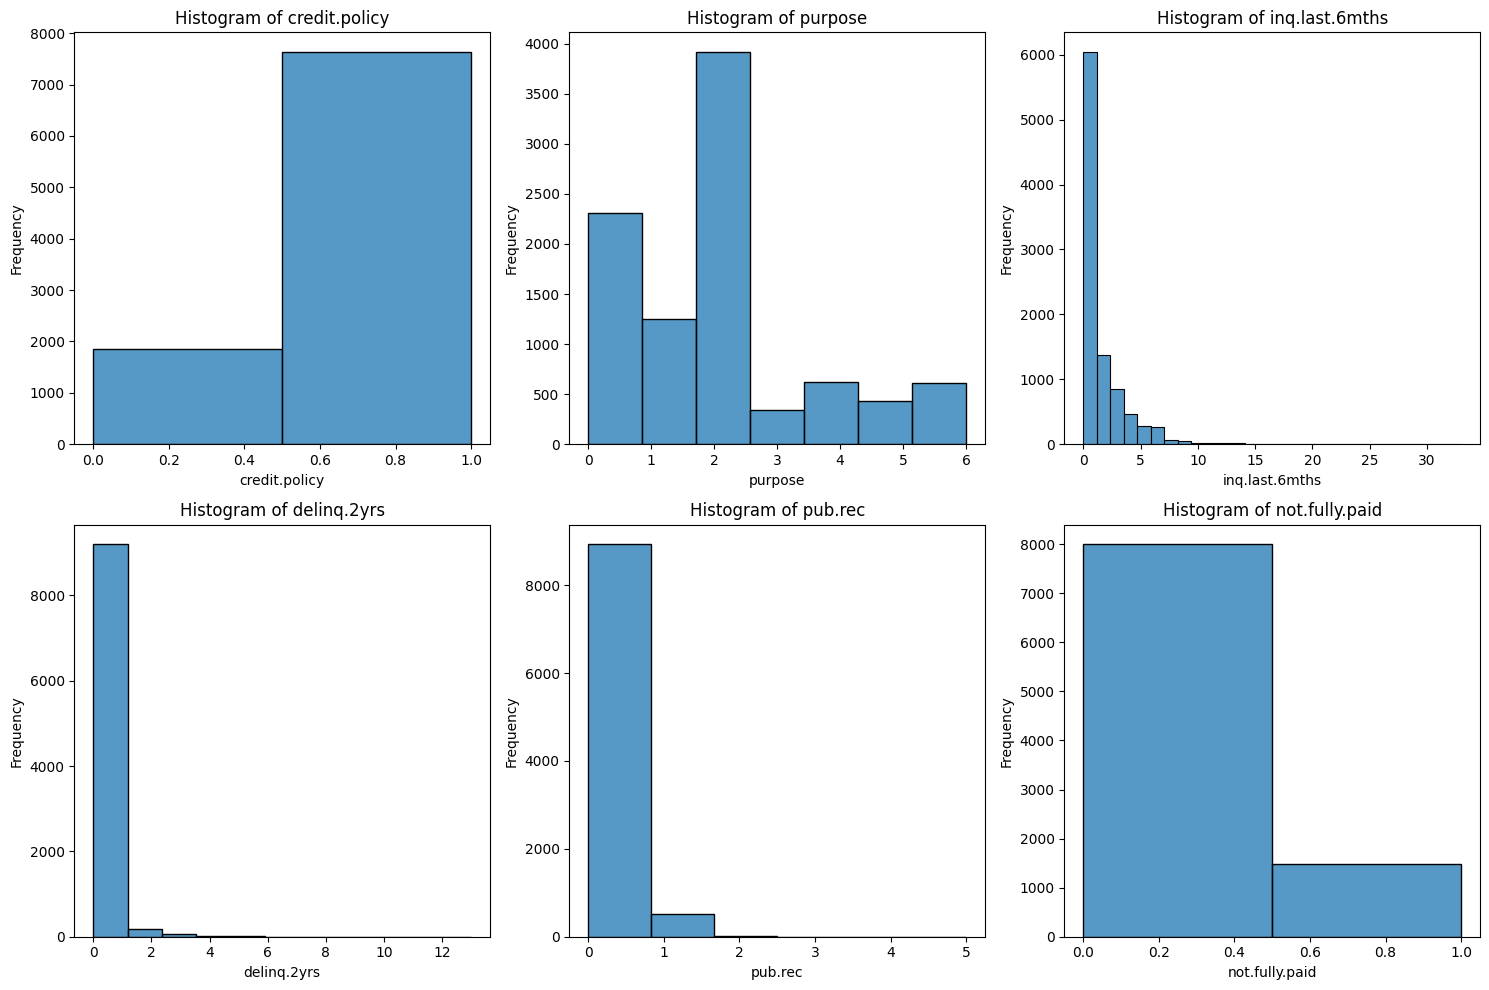

In [73]:
variables = ['credit.policy', 'purpose', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']

for var in variables:
    unique_values = data[var].unique()
    unique_values = sorted(unique_values)
    print(f"Unique values in {var} : {unique_values}")

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[var], kde=False, bins=len(data[var].unique()))
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


- 極端值處理：installment, days.with.cr.line, revol.bal 這三個 feature 的偏態係數較大，故以 Q1-1.5*IQR 與 Q3+1.5*IQR為界

In [74]:
def Outlier_IQR(data, columns):
    '''透過 IQR 處理極端值'''
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        maxOutlier = Q3 + IQR * 1.5
        minOutlier = Q1 - IQR * 1.5
        data[column] = data[column].clip(lower=minOutlier, upper=maxOutlier)
    return data

IQRVars = ['installment', 'days.with.cr.line', 'revol.bal']
data = Outlier_IQR(data, IQRVars)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,0,1,0.1197,6.178774,11.775290,10.85,682,8.531490,6.874198,13.1,5,0,0,0
1,1,0,0.0907,5.479597,11.002100,4.86,752,8.939576,9.056723,25.0,1,0,0,0
2,1,2,0.1222,5.005824,11.835009,19.00,677,8.709623,10.225136,74.8,1,1,0,0
3,1,0,0.0774,5.056883,10.803649,4.71,797,8.343088,7.170120,4.2,2,0,0,0
4,0,5,0.1253,5.593707,10.819778,21.29,697,8.026511,10.461359,59.6,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9473,1,4,0.1253,4.904311,10.858999,1.34,742,7.479300,7.777793,11.3,4,0,0,1
9474,1,3,0.1253,5.125986,10.308953,0.00,697,7.528869,0.000000,0.0,1,1,0,1
9475,1,1,0.1461,6.730912,11.695247,20.52,707,8.627123,10.618528,84.3,2,0,0,1
9476,1,0,0.0894,5.723618,11.350407,12.01,742,8.525351,10.618528,56.1,0,0,0,1


- 取nutural log：使用 numpy 中的 numpy.log1p 進行轉換，避免 feature 原本為0的情況
    1. 針對所有非類別變數進行對數化 logVars
    2. 針對偏態係數較大的 feature 進行對數化 IQRVars

In [2]:
def Netural_log(data, columns):
    '''取自然對數轉換'''
    for column in columns:
        data[column] = np.log1p(data[column])
    return data

- feature 標準化
    1. standardization
    2. min-max scaling

In [75]:
def Standard_data(data, method):
    ''' 資料標準化 '''
    stdVars = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
    if method == 'standardization':
        scaler = StandardScaler()
    elif method == 'min-max scaling':
        scaler = MinMaxScaler()
    else:
        raise ValueError("standard_data method must be either 'standardization' or 'min-max scaling'")
    data[stdVars] = scaler.fit_transform(data[stdVars])
    return data

Standard_data(data, 'standardization')

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,0,1,-0.108792,0.883165,1.371606,-0.254420,-0.760466,0.457944,-0.798699,-1.159523,5,0,0,0
1,1,0,-1.188276,-0.076710,0.112801,-1.124810,1.081185,1.145983,0.235170,-0.749289,1,0,0,0
2,1,2,-0.015733,-0.727136,1.468833,0.929832,-0.892012,0.758279,0.788651,0.967489,1,1,0,0
3,1,0,-1.683350,-0.657039,-0.210290,-1.146606,2.265104,0.140293,-0.658520,-1.466337,2,0,0,0
4,0,5,0.099660,0.079949,-0.184030,1.262585,-0.365826,-0.393463,0.900550,0.443493,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9473,1,4,0.099660,-0.866498,-0.120177,-1.636290,0.818092,-1.316072,-0.370663,-1.221575,4,0,0,1
9474,1,3,0.099660,-0.562169,-1.015689,-1.831002,-0.365826,-1.232497,-4.055027,-1.611125,1,1,0,1
9475,1,1,0.873910,1.641177,1.241291,1.150699,-0.102733,0.619182,0.975001,1.294987,2,0,0,1
9476,1,0,-1.236667,0.258298,0.679868,-0.085864,0.818092,0.447593,0.975001,0.322836,0,0,0,1


- feature 之間的相關性
    結論：'fico' 'int.rate' 是相關性最大的兩個變數，但仍然只有-0.72，無需考慮共線性問題。

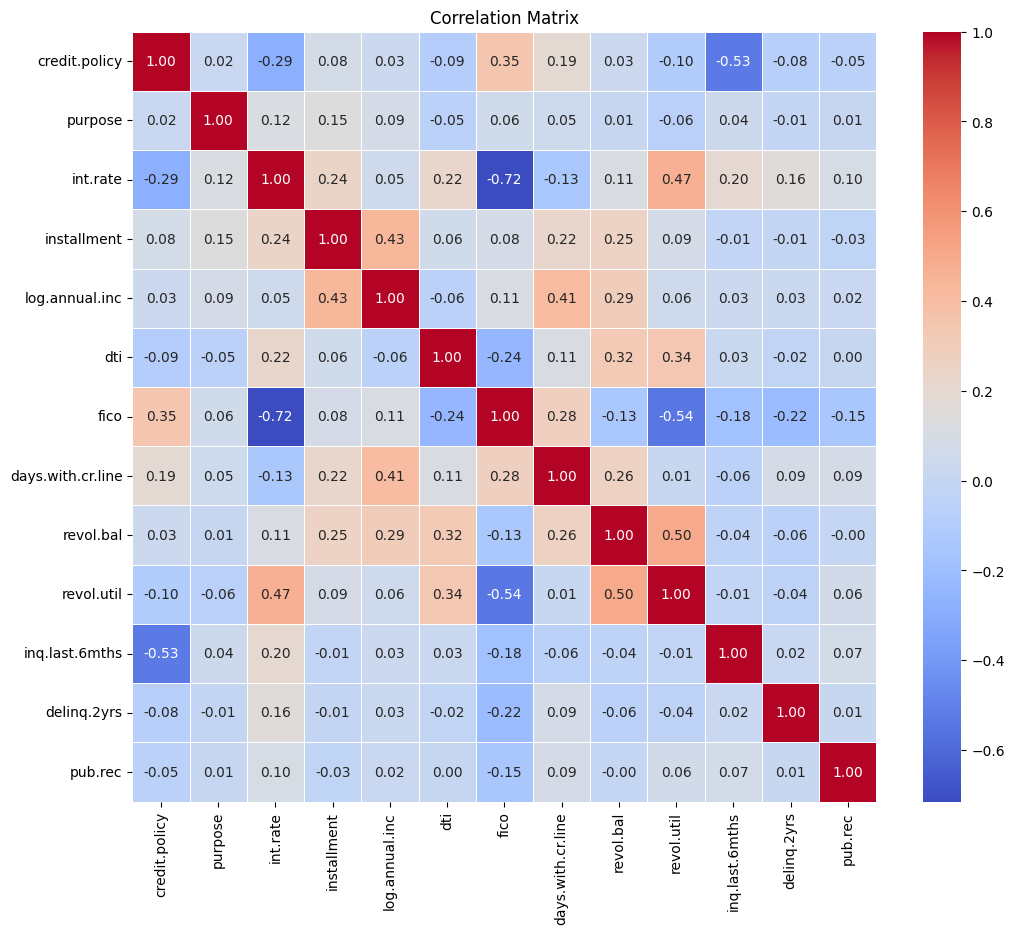

In [76]:
data_to_plot = data.drop(columns=['not.fully.paid'])

correlation_matrix = data_to_plot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- 各 feature 與 'not.fully.paid' 之間的相關性

C:\Users\chewei\AppData\Local\Temp\ipykernel_30360\1581495434.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm')


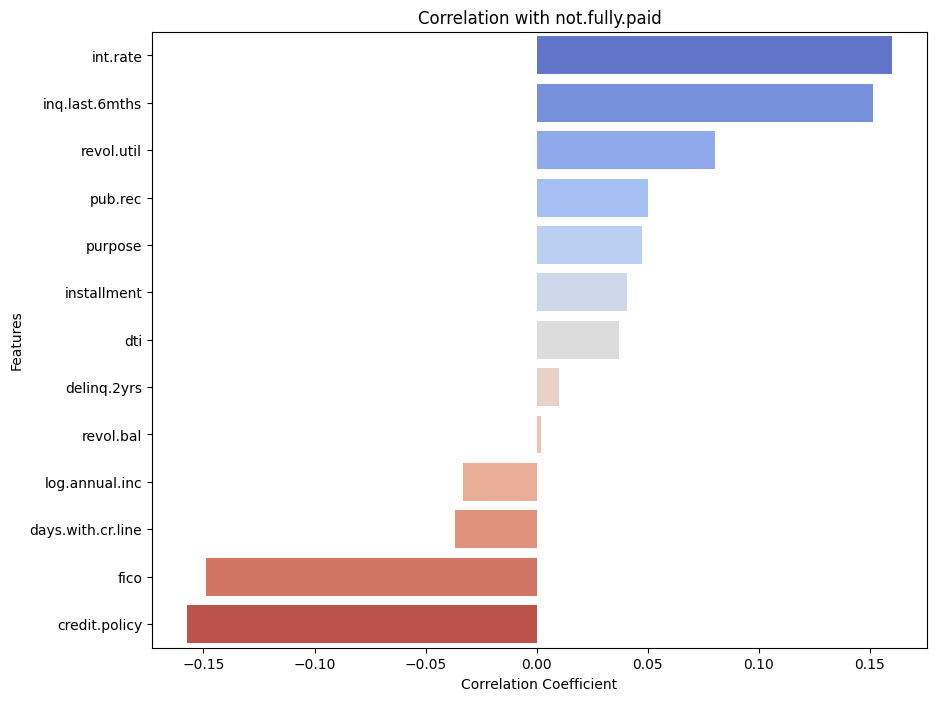

In [77]:
correlations = data.corr()['not.fully.paid'].drop('not.fully.paid')

sorted_correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm')
plt.title('Correlation with not.fully.paid')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

- split data
    將 data 分成 training data 與 testing data，比例為0.7
    - undersampling：將 training data 中 not.fully.paid == 0 的筆數降至1483，與 not.fully.paid == 1相同
    - oversampling：
        1. SMOTE
        2. ADASYN
        3. BorerlineSMOTH
        4. SVMSMOTE

In [78]:
def split_data(data, size, seed, method):
    '''split data, training data的方法'''
    data_paid = data[data['not.fully.paid'] == 0]
    data_unpaid = data[data['not.fully.paid'] == 1]
    
    data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
    data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
    if method == 'Undersampling':
        data_paid = data[data['not.fully.paid'] == 0]
        data_unpaid = data[data['not.fully.paid'] == 1]
        
        data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
        data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
        data_paid_train = data_paid_train.sample(1483, random_state=seed)
    
        data_train = pd.concat([data_paid_train, data_unpaid_train], ignore_index=True)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_train = data_train.drop('not.fully.paid', axis=1)
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_train = data_train['not.fully.paid']
        y_test = data_test['not.fully.paid']
    else:
        x_train = pd.concat([data_paid_train, data_unpaid_train]).drop('not.fully.paid', axis=1)
        y_train = pd.concat([data_paid_train, data_unpaid_train])['not.fully.paid']
        
        if len(y_train.unique()) > 1:
            if method == 'SMOTE':
                sampler = SMOTE(random_state=seed)
            elif method == 'ADASYN':
                sampler = ADASYN(random_state=seed)
            elif method == 'BorderlineSMOTE':
                sampler = BorderlineSMOTE(random_state=seed)
            elif method == 'SVMSMOTE':
                sampler = SVMSMOTE(random_state=seed)
            else:
                raise ValueError(f"Unknown oversampling method: {method}")
            
            x_train, y_train = sampler.fit_resample(x_train, y_train)
        
        data_train = pd.concat([x_train, y_train], axis=1)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_test = data_test['not.fully.paid']
    
    return data_train, data_test, x_train, x_test, y_train, y_test

data_train, data_test, x_train, x_test, y_train, y_test = split_data(data, 0.7, random_state, training)

## 特徵篩選

- feature select
    1. forward stepwise selection
    2. lasso regression
    3. ridge regression
    4. Kbest selection

In [79]:
def forward_stepwise_selection(data):
    '''使用 forward stepwise 進行變數篩選'''
    x = data.drop('not.fully.paid', axis=1)
    x = np.array(x)
    y = data['not.fully.paid'].astype(float)
    y = np.array(y)
    y = y[:, np.newaxis]
    n, k = x.shape
    
    SST = y.T@y
    remainingIndices = list(range(k))
    selectedIndices = []
    xk = x[:, selectedIndices]
    AIC = np.zeros((k+1, 1))
    AIC[0, 0] = SST /n
 
    minAIC = np.inf
    minAIC_indices = []

    for i in range(k):
        Rsquared = np.zeros([k]) - 999
        for m in remainingIndices:
            x1 = np.concatenate((xk, x[:, m:m+1]), axis=1)
            bhats = inv(x1.T@x1)@x1.T@y
            SSR = (y-x1@bhats).T @ (y-x1@bhats)
            Rsquared[m] = (1-SSR/SST).item()
        '''求出使 R squared 最大的 X並加入selectedIndices中'''
        selectedIndices.append(np.argmax(Rsquared))         
        remainingIndices.remove(selectedIndices[-1])        
        xk = x[:, selectedIndices]
        AIC[i+1, 0] = (y - xk @ inv(xk.T@xk) @ xk.T@y).T@(y - xk @ inv(xk.T@xk) @ xk.T@y) / n + 2*(i+1)/n
        
        '''select the minimum AIC'''
        if AIC[i+1, 0] < minAIC:
            minAIC = AIC[i+1, 0]
            minAIC_indices = selectedIndices.copy()
            
        selectedIndices_name = data.columns[selectedIndices].tolist()
        minAIC_indicesName = data.columns[minAIC_indices].tolist()
    return minAIC_indicesName

def lasso_selection(x_train, y_train, alpha):
    '''使用 lasso 進行變數篩選'''
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    coef = lasso.coef_
    selected_features = x_train.columns[coef != 0].tolist()
    return selected_features

def ridge_selection(x_train, y_train, alpha):
    '''使用 ridge 進行變數篩選'''
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train) 
    coef = ridge.coef_
    selected_features = x_train.columns[abs(coef) > 1e-5].tolist()
    return selected_features

def SelectKBest_selection(x_train, y_train, k):
    '''使用 kbest 進行變數篩選'''
    selector = SelectKBest(score_func=f_classif, k=k)
    selected_features = selector.fit_transform(data.drop('not.fully.paid', axis=1), data['not.fully.paid'])
    selected_feature_names = data.drop('not.fully.paid', axis=1).columns[selector.get_support()].tolist()
    return selected_feature_names


selectedFeatures_forward = forward_stepwise_selection(data_train)
selectedFeatures_lasso = lasso_selection(x_train, y_train, alpha=0.01)
selectedFeatures_ridge = ridge_selection(x_train, y_train, alpha=0.01)
selectedFeautres_kbest = SelectKBest_selection(x_train, y_train, k=10)


print("Forward Selection 選擇的特徵:", selectedFeatures_forward)
print("Lasso Selection 選擇的特徵:", selectedFeatures_lasso)
print("Ridge Selection 選擇的特徵:", selectedFeatures_ridge)
print("SelectKBest Selection 選擇的特徵:", selectedFeautres_kbest)

C:\Users\chewei\AppData\Local\Temp\ipykernel_30360\1041522521.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AIC[0, 0] = SST /n
C:\Users\chewei\AppData\Local\Temp\ipykernel_30360\1041522521.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AIC[i+1, 0] = (y - xk @ inv(xk.T@xk) @ xk.T@y).T@(y - xk @ inv(xk.T@xk) @ xk.T@y) / n + 2*(i+1)/n


Forward Selection 選擇的特徵: ['inq.last.6mths', 'purpose', 'fico', 'credit.policy']
Lasso Selection 選擇的特徵: ['purpose', 'int.rate', 'log.annual.inc', 'fico', 'inq.last.6mths']
Ridge Selection 選擇的特徵: ['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec']
SelectKBest Selection 選擇的特徵: ['credit.policy', 'purpose', 'int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.util', 'inq.last.6mths', 'pub.rec']


- 將 feature 適配至不同的特徵選擇方法

In [80]:
def data_features(method):
    if method == 'forward':        
        xTrain = x_train[selectedFeatures_forward]
        xTest = x_test[selectedFeatures_forward]
    elif method == 'lasso':
        xTrain = x_train[selectedFeatures_lasso]
        xTest = x_test[selectedFeatures_lasso]
    elif method == 'ridge':
        xTrain = x_train[selectedFeatures_ridge]
        xTest = x_test[selectedFeatures_ridge]
    elif method == 'kbest':
        xTrain = x_train[selectedFeautres_kbest]
        xTest = x_test[selectedFeautres_kbest]
    else:
        raise ValueError("method must be 'forward', 'lasso', 'ridge' or 'kbest'")
    return xTrain, xTest

x_train, x_test = data_features(method = 'lasso')

## 模型

- model 並計算其 accuracy, precision, recall, F1-score 及 best parameters

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,)),
    'Voting Classifier': VotingClassifier(
        estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('svm', SVC())],
        voting='hard'
    ),
    'Bagging Classifier': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100
    ),

    'XGBoost Classifier': XGBClassifier(
        n_estimators=100
    ),
    'LightGBM': LGBMClassifier(n_estimators=100),
}

param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    'Voting Classifier': {},
    'Bagging Classifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0]
    },
    'XGBoost Classifier': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    }
}


def model_accuracy_maximum(X_train, X_test, y_train, y_test, models, param_grid, seed):
    results = []
    best_model_overall = None
    best_accuracy_overall = 0
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        if model_name in param_grid:
            param_combinations = [dict(zip(param_grid[model_name].keys(), v)) for v in product(*param_grid[model_name].values())]
            best_model = None
            best_accuracy = 0
            best_params = None
            
            for params in param_combinations:
                model.set_params(**params)
                if hasattr(model, 'random_state'):
                    model.set_params(random_state=seed)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                if accuracy > best_accuracy:
                    best_model = model
                    best_accuracy = accuracy
                    best_params = params
            
            if best_accuracy > best_accuracy_overall:
                best_model_overall = best_model
                best_accuracy_overall = best_accuracy
        else:
            if hasattr(model, 'random_state'):
                model.set_params(random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if accuracy > best_accuracy_overall:
                best_model_overall = model
                best_accuracy_overall = accuracy
                best_params = {}
                
                
        y_pred = best_model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append([model_name, best_accuracy, precision, recall, f1, best_params])
    
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Best Parameters'])
    

    
    return df_results

# 使用示例
df_model_results = model_accuracy_maximum(x_train, x_test, y_train, y_test, models, param_grid, random_state)

# 結論

## 平時測試完整code

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 21:28:16 2024

@author: chewei
"""

import pandas as pd
import numpy as np


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from itertools import product


data = pd.read_csv(r"C:\Users\chewei\Documents\python-practice\machine learning\final project\loan.csv")
random_state = 1117

def Purpose_transformation(data, method):
    '''將 purpose 的型態轉換'''
    if method == 'label':
        label_encoder = LabelEncoder()
        data['purpose'] = label_encoder.fit_transform(data['purpose'])
    elif method in ['dummy', 'one_hot']:
        data = pd.get_dummies(data=data, columns=['purpose'], drop_first=True)
        data[['purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 
              'purpose_small_business']] = data[['purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']].astype(int)
        order = ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 
                 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business', 'not.fully.paid']
        data = data[order]
    else:    
        raise ValueError("Method must be either 'label' or 'one_hot'")
    return data

def Outlier_IQR(data, columns):
    '''透過 IQR 處理極端值'''
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        maxOutlier = Q3 + IQR * 1.5
        minOutlier = Q1 - IQR * 1.5
        data[column] = data[column].clip(lower=minOutlier, upper=maxOutlier)
    return data

def Netural_log(data, columns):
    '''取自然對數轉換'''
    for column in columns:
        data[column] = np.log1p(data[column])
    return data

def Standard_data(data, columns, method):
    '''資料標準化'''
    if method == 'standardization':
        scaler = StandardScaler()
    elif method == 'min-max scaling':
        scaler = MinMaxScaler()
    else:
        raise ValueError("standard_data method must be either 'standardization' or 'min-max scaling'")
    
    data[columns] = scaler.fit_transform(data[columns])
    return data


def split_data(data, size, seed, method):
    '''split data, training data的方法'''
    data_paid = data[data['not.fully.paid'] == 0]
    data_unpaid = data[data['not.fully.paid'] == 1]
    
    data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
    data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
    if method == 'undersampling':
        data_paid = data[data['not.fully.paid'] == 0]
        data_unpaid = data[data['not.fully.paid'] == 1]
        
        data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
        data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
        data_paid_train = data_paid_train.sample(1483, random_state=seed)
    
        data_train = pd.concat([data_paid_train, data_unpaid_train], ignore_index=True)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_train = data_train.drop('not.fully.paid', axis=1)
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_train = data_train['not.fully.paid']
        y_test = data_test['not.fully.paid']
    else:
        x_train = pd.concat([data_paid_train, data_unpaid_train]).drop('not.fully.paid', axis=1)
        y_train = pd.concat([data_paid_train, data_unpaid_train])['not.fully.paid']
        
        if len(y_train.unique()) > 1:
            if method == 'SMOTE':
                sampler = SMOTE(random_state=seed)
            elif method == 'ADASYN':
                sampler = ADASYN(random_state=seed)
            elif method == 'BorderlineSMOTE':
                sampler = BorderlineSMOTE(random_state=seed)
            elif method == 'SVMSMOTE':
                sampler = SVMSMOTE(random_state=seed)
            else:
                raise ValueError(f"Unknown oversampling method: {method}")
            
            x_train, y_train = sampler.fit_resample(x_train, y_train)
        
        data_train = pd.concat([x_train, y_train], axis=1)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_test = data_test['not.fully.paid']
    
    return data_train, data_test, x_train, x_test, y_train, y_test


def forward_stepwise_selection(data):
    '''使用 forward stepwise 進行變數篩選'''
    x = data.drop('not.fully.paid', axis=1)
    x = np.array(x)
    y = data['not.fully.paid'].astype(float)
    y = np.array(y)
    y = y[:, np.newaxis]
    n, k = x.shape
    
    SST = y.T@y
    remainingIndices = list(range(k))
    selectedIndices = []
    xk = x[:, selectedIndices]
    AIC = np.zeros((k+1, 1))
    AIC[0, 0] = SST /n
 
    minAIC = np.inf
    minAIC_indices = []

    for i in range(k):
        Rsquared = np.zeros([k]) - 999
        for m in remainingIndices:
            x1 = np.concatenate((xk, x[:, m:m+1]), axis=1)
            bhats = inv(x1.T@x1)@x1.T@y
            SSR = (y-x1@bhats).T @ (y-x1@bhats)
            Rsquared[m] = (1-SSR/SST).item()
        '''求出使 R squared 最大的 X並加入selectedIndices中'''
        selectedIndices.append(np.argmax(Rsquared))         
        remainingIndices.remove(selectedIndices[-1])        
        xk = x[:, selectedIndices]
        AIC[i+1, 0] = (y - xk @ inv(xk.T@xk) @ xk.T@y).T@(y - xk @ inv(xk.T@xk) @ xk.T@y) / n + 2*(i+1)/n
        
        '''select the minimum AIC'''
        if AIC[i+1, 0] < minAIC:
            minAIC = AIC[i+1, 0]
            minAIC_indices = selectedIndices.copy()
            
        minAIC_indicesName = data.columns[minAIC_indices].tolist()
    return minAIC_indicesName

def lasso_selection(x_train, y_train, alpha):
    '''使用 lasso 進行變數篩選'''
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    coef = lasso.coef_
    selected_features = x_train.columns[coef != 0].tolist()
    return selected_features

def ridge_selection(x_train, y_train, alpha):
    '''使用 ridge 進行變數篩選'''
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train) 
    coef = ridge.coef_
    selected_features = x_train.columns[abs(coef) > 1e-5].tolist()
    return selected_features

def SelectKBest_selection(x_train, y_train, k):
    '''使用 kbest 進行變數篩選'''
    selector = SelectKBest(score_func=f_classif, k=k)
    selected_features = selector.fit_transform(data.drop('not.fully.paid', axis=1), data['not.fully.paid'])
    selected_feature_names = data.drop('not.fully.paid', axis=1).columns[selector.get_support()].tolist()
    return selected_feature_names

def data_features(x_train, x_test, method):
    ''' 使用不同 feature selection 的結果更新 data'''
    if method == 'forward':        
        xTrain = x_train[selectedFeatures_forward]
        xTest = x_test[selectedFeatures_forward]
    elif method == 'lasso':
        xTrain = x_train[selectedFeatures_lasso]
        xTest = x_test[selectedFeatures_lasso]
    elif method == 'ridge':
        xTrain = x_train[selectedFeatures_ridge]
        xTest = x_test[selectedFeatures_ridge]
    elif method == 'kbest':
        xTrain = x_train[selectedFeautres_kbest]
        xTest = x_test[selectedFeautres_kbest]
    else:
        raise ValueError("method must be 'forward', 'lasso', 'ridge' or 'kbest'")
    return xTrain, xTest

def model_accuracy_maximum(X_train, X_test, y_train, y_test, models, param_grid, seed):
    results = []
    best_model_overall = None
    best_accuracy_overall = 0
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        if model_name in param_grid:
            param_combinations = [dict(zip(param_grid[model_name].keys(), v)) for v in product(*param_grid[model_name].values())]
            best_model = None
            best_accuracy = 0
            best_params = None
            
            for params in param_combinations:
                model.set_params(**params)
                if hasattr(model, 'random_state'):
                    model.set_params(random_state=seed)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                if accuracy > best_accuracy:
                    best_model = model
                    best_accuracy = accuracy
                    best_params = params
            
            if best_accuracy > best_accuracy_overall:
                best_model_overall = best_model
                best_accuracy_overall = best_accuracy
        else:
            if hasattr(model, 'random_state'):
                model.set_params(random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if accuracy > best_accuracy_overall:
                best_model_overall = model
                best_accuracy_overall = accuracy
                best_params = {}
                
                
        y_pred = best_model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append([model_name, best_accuracy, precision, recall, f1, best_params])
    
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Best Parameters'])
    
    return df_results

def run_selected_model(model_name, X_train, X_test, y_train, y_test, seed):
    models = {
        'Decision Tree': DecisionTreeClassifier(max_depth=None, min_samples_split=10),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7),
        'Bagging Classifier': BaggingClassifier(n_estimators=50, max_samples=0.7),
        'LightGBM_1': LGBMClassifier(n_estimators=200, learning_rate=1, max_depth=7),
        'LightGBM_2': LGBMClassifier(n_estimators=50, learning_rate=1, max_depth=3),
    }
    
    if model_name not in models:
        print(f"無效的模型名稱：{model_name}")
        return None
    
    model = models[model_name]
    
    print(f"訓練 {model_name}...")
    
    if hasattr(model, 'random_state'):
        model.set_params(random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1]
    })
    
    return results

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,)),
    'Voting Classifier': VotingClassifier(
        estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('svm', SVC())],
        voting='hard'
    ),
    'Bagging Classifier': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100
    ),

    'XGBoost Classifier': XGBClassifier(
        n_estimators=100
    ),
    'LightGBM': LGBMClassifier(n_estimators=100),
}

param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    'Voting Classifier': {},
    'Bagging Classifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0]
    },
    'XGBoost Classifier': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    }
}

IQRVars = ['installment', 'days.with.cr.line', 'revol.bal']
logVars = ['int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
stdVars = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']


#%%

data = Purpose_transformation(data, 'label')
data = Outlier_IQR(data, IQRVars)
data = Netural_log(data, logVars)
data = Standard_data(data, stdVars, 'standardization')
data_train, data_test, x_train, x_test, y_train, y_test = split_data(data, 0.7, random_state, 'undersampling')

selectedFeatures_forward = forward_stepwise_selection(data_train)
selectedFeatures_lasso = lasso_selection(x_train, y_train, alpha=0.01)
selectedFeatures_ridge = ridge_selection(x_train, y_train, alpha=0.01)
selectedFeautres_kbest = SelectKBest_selection(x_train, y_train, k=10)
x_train, x_test = data_features(x_train, x_test, 'forward')


test = pd.read_csv(r"C:\Users\chewei\Desktop\ya.csv")
test = Purpose_transformation(test, 'label')
test = Outlier_IQR(test, IQRVars)
test = Netural_log(test, logVars)
test = Standard_data(test, stdVars, 'standardization')

x_test = test.drop('not.fully.paid', axis=1)
y_test = test['not.fully.paid']
x_train, x_test = data_features(x_train, x_test, 'forward')


df_model_results = model_accuracy_maximum(x_train, x_test, y_train, y_test, models, param_grid, random_state)

## 最好的5個model
1. Decision Tree：(max_depth=None, min_samples_split=10)
2. Gradient Boosting: (n_estimators=100, learning_rate=1, max_depth=7)
3. Bagging Classifier: (n_estimators=50, max_samples=0.7)
4. LightGBM_1: (n_estimators=200, learning_rate=1, max_depth=7)
5. LightGBM_2: (n_estimators=50, learning_rate=1, max_depth=3)

In [32]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 21:17:18 2024

@author: chewei

final best 5

"""

import pandas as pd
import numpy as np


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from itertools import product


data = pd.read_csv(r"C:\Users\chewei\Documents\python-practice\machine learning\final project\loan.csv")
random_state = 1117


def model_parameters(model):
    purpose = None
    log = None
    std = None
    training = None
    select = None
    
    if model == 'Decision Tree':
        purpose = 'dummy'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business'
    elif model == 'Gradient Boosting':
        purpose = 'label'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'purpose', 'int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.util', 'inq.last.6mths', 'pub.rec'
    elif model == 'Bagging Classifier':
        purpose = 'label'
        log = IQRVars
        std = 'standardization'
        training = 'undersampling'
        select = 'purpose', 'inq.last.6mths', 'credit.policy', 'fico', 'int.rate'
    elif model == 'LightGBM_1':
        purpose = 'dummy'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business'
    elif model == 'LightGBM_2':
        purpose = 'dummy'
        log = logVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'fico', 'inq.last.6mths' , 'purpose_credit_card', 'purpose_small_business'
    
    return purpose, log, std, training, select

def Purpose_transformation(data, method):
    '''將 purpose 的型態轉換'''
    if method == 'label':
        label_encoder = LabelEncoder()
        data['purpose'] = label_encoder.fit_transform(data['purpose'])
    elif method in ['dummy', 'one_hot']:
        data = pd.get_dummies(data=data, columns=['purpose'], drop_first=True)
        data[dummyVars] = data[dummyVars].astype(int)
        data = data[Vars]
    else:    
        raise ValueError("Method must be either 'label' or 'one_hot'")
    return data

def Outlier_IQR(data, columns):
    '''透過 IQR 處理極端值'''
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        maxOutlier = Q3 + IQR * 1.5
        minOutlier = Q1 - IQR * 1.5
        data[column] = data[column].clip(lower=minOutlier, upper=maxOutlier)
    return data

def Netural_log(data, columns):
    '''取自然對數轉換'''
    for column in columns:
        data[column] = np.log1p(data[column])
    return data

def Standard_data(data, columns, method):
    '''資料標準化'''
    if method == 'standardization':
        scaler = StandardScaler()
    elif method == 'min-max scaling':
        scaler = MinMaxScaler()
    else:
        raise ValueError("standard_data method must be either 'standardization' or 'min-max scaling'")
    
    data[columns] = scaler.fit_transform(data[columns])
    return data


def split_data(data, size, seed, method):
    '''split data, training data的方法'''
    data_paid = data[data['not.fully.paid'] == 0]
    data_unpaid = data[data['not.fully.paid'] == 1]
    
    data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
    data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
    if method == 'undersampling':
        data_paid = data[data['not.fully.paid'] == 0]
        data_unpaid = data[data['not.fully.paid'] == 1]
        
        data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
        data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
        data_paid_train = data_paid_train.sample(1483, random_state=seed)
    
        data_train = pd.concat([data_paid_train, data_unpaid_train], ignore_index=True)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_train = data_train.drop('not.fully.paid', axis=1)
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_train = data_train['not.fully.paid']
        y_test = data_test['not.fully.paid']
    else:
        x_train = pd.concat([data_paid_train, data_unpaid_train]).drop('not.fully.paid', axis=1)
        y_train = pd.concat([data_paid_train, data_unpaid_train])['not.fully.paid']
        
        if len(y_train.unique()) > 1:
            if method == 'SMOTE':
                sampler = SMOTE(random_state=seed)
            elif method == 'ADASYN':
                sampler = ADASYN(random_state=seed)
            elif method == 'BorderlineSMOTE':
                sampler = BorderlineSMOTE(random_state=seed)
            elif method == 'SVMSMOTE':
                sampler = SVMSMOTE(random_state=seed)
            else:
                raise ValueError(f"Unknown oversampling method: {method}")
            
            x_train, y_train = sampler.fit_resample(x_train, y_train)
        
        data_train = pd.concat([x_train, y_train], axis=1)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_test = data_test['not.fully.paid']
    
    return data_train, data_test, x_train, x_test, y_train, y_test

def data_features(x_train, x_test, selectedFeatures):   
    selectedFeatures = list(selectedFeatures)
    xTrain = x_train[selectedFeatures]
    xTest = x_test[selectedFeatures]
    
    return xTrain, xTest

def model_accuracy_maximum(X_train, X_test, y_train, y_test, models, param_grid, seed):
    results = []
    best_model_overall = None
    best_accuracy_overall = 0
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        if model_name in param_grid:
            param_combinations = [dict(zip(param_grid[model_name].keys(), v)) for v in product(*param_grid[model_name].values())]
            best_model = None
            best_accuracy = 0
            best_params = None
            
            for params in param_combinations:
                model.set_params(**params)
                if hasattr(model, 'random_state'):
                    model.set_params(random_state=seed)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                if accuracy > best_accuracy:
                    best_model = model
                    best_accuracy = accuracy
                    best_params = params
            
            if best_accuracy > best_accuracy_overall:
                best_model_overall = best_model
                best_accuracy_overall = best_accuracy
        else:
            if hasattr(model, 'random_state'):
                model.set_params(random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if accuracy > best_accuracy_overall:
                best_model_overall = model
                best_accuracy_overall = accuracy
                best_params = {}
                
                
        y_pred = best_model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append([model_name, best_accuracy, precision, recall, f1, best_params])
    
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Best Parameters'])
    
    return df_results

def best_5_model(model_name, X_train, X_test, y_train, y_test, seed):
    models = {
        'Decision Tree': DecisionTreeClassifier(max_depth=None, min_samples_split=10),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7),
        'Bagging Classifier': BaggingClassifier(n_estimators=50, max_samples=0.7),
        'LightGBM_1': LGBMClassifier(n_estimators=200, learning_rate=1, max_depth=7),
        'LightGBM_2': LGBMClassifier(n_estimators=50, learning_rate=1, max_depth=3),
    }
    
    if model_name not in models:
        print(f"無效的模型名稱：{model_name}")
        return None
    
    model = models[model_name]
    
    print(f"訓練 {model_name}...")
    
    if hasattr(model, 'random_state'):
        model.set_params(random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1]
    })
    
    return results

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,)),
    'Voting Classifier': VotingClassifier(
        estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('svm', SVC())],
        voting='hard'
    ),
    'Bagging Classifier': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100
    ),

    'XGBoost Classifier': XGBClassifier(
        n_estimators=100
    ),
    'LightGBM': LGBMClassifier(n_estimators=100),
}

param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    'Voting Classifier': {},
    'Bagging Classifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0]
    },
    'XGBoost Classifier': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 9]
    }
}


dummyVars = ['purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']
Vars = ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec'] + dummyVars + ['not.fully.paid']
IQRVars = ['installment', 'days.with.cr.line', 'revol.bal']
logVars = ['int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
stdVars = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']



models = ['Decision Tree', 'Gradient Boosting', 'Bagging Classifier', 'LightGBM_1', 'LightGBM_2']
all_results = []

for modelName in models:

    data = pd.read_csv(r"C:\Users\chewei\Documents\python-practice\machine learning\final project\loan.csv")
    
    purpose, log, std, training, select =  model_parameters(modelName)

    data = Purpose_transformation(data, purpose)
    data = Outlier_IQR(data, IQRVars)
    data = Netural_log(data, log)
    data = Standard_data(data, stdVars, std)
    data_train, data_test, x_train, x_test, y_train, y_test = split_data(data, 0.7, random_state, training)

    x_train, x_test = data_features(x_train, x_test, select)

    modelResults = best_5_model(modelName, x_train, x_test, y_train, y_test, random_state)
    all_results.append(modelResults)

# 將所有結果合併為一個 DataFrame
final_results = pd.concat(all_results, ignore_index=True)
print(final_results)



訓練 Decision Tree...
訓練 Gradient Boosting...
訓練 Bagging Classifier...
訓練 LightGBM_1...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1038, number of negative: 1483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411741 -> initscore=-0.356771
[LightGBM] [Info] Start training from score -0.356771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

## test code

In [31]:

# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 21:17:18 2024

@author: chewei

final test code

"""

import pandas as pd
import numpy as np


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from itertools import product


data = pd.read_csv(r"C:\Users\chewei\Documents\python-practice\machine learning\final project\loan.csv")
random_state = 1117



def model_parameters(model):
    purpose = None
    log = None
    std = None
    training = None
    select = None
    
    if model == 'Decision Tree':
        purpose = 'dummy'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business'
    elif model == 'Gradient Boosting':
        purpose = 'label'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'purpose', 'int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.util', 'inq.last.6mths', 'pub.rec'
    elif model == 'Bagging Classifier':
        purpose = 'label'
        log = IQRVars
        std = 'standardization'
        training = 'undersampling'
        select = 'purpose', 'inq.last.6mths', 'credit.policy', 'fico', 'int.rate'
    elif model == 'LightGBM_1':
        purpose = 'dummy'
        log = IQRVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business'
    elif model == 'LightGBM_2':
        purpose = 'dummy'
        log = logVars
        std = 'min-max scaling'
        training = 'undersampling'
        select = 'credit.policy', 'int.rate', 'fico', 'inq.last.6mths' , 'purpose_credit_card', 'purpose_small_business'
    
    return purpose, log, std, training, select

def Purpose_transformation(data, method):
    '''將 purpose 的型態轉換'''
    if method == 'label':
        label_encoder = LabelEncoder()
        data['purpose'] = label_encoder.fit_transform(data['purpose'])
    elif method in ['dummy', 'one_hot']:
        data = pd.get_dummies(data=data, columns=['purpose'], drop_first=True)
        data[dummyVars] = data[dummyVars].astype(int)
        data = data[Vars]
    else:    
        raise ValueError("Method must be either 'label' or 'one_hot'")
    return data

def Outlier_IQR(data, columns):
    '''透過 IQR 處理極端值'''
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        maxOutlier = Q3 + IQR * 1.5
        minOutlier = Q1 - IQR * 1.5
        data[column] = data[column].clip(lower=minOutlier, upper=maxOutlier)
    return data

def Netural_log(data, columns):
    '''取自然對數轉換'''
    for column in columns:
        data[column] = np.log1p(data[column])
    return data

def Standard_data(data, columns, method):
    '''資料標準化'''
    if method == 'standardization':
        scaler = StandardScaler()
    elif method == 'min-max scaling':
        scaler = MinMaxScaler()
    else:
        raise ValueError("standard_data method must be either 'standardization' or 'min-max scaling'")
    
    data[columns] = scaler.fit_transform(data[columns])
    return data


def split_data(data, size, seed, method):
    '''split data, training data的方法'''
    data_paid = data[data['not.fully.paid'] == 0]
    data_unpaid = data[data['not.fully.paid'] == 1]
    
    data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
    data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
    if method == 'undersampling':
        data_paid = data[data['not.fully.paid'] == 0]
        data_unpaid = data[data['not.fully.paid'] == 1]
        
        data_paid_train, data_paid_test = train_test_split(data_paid, train_size=size, random_state=seed)
        data_unpaid_train, data_unpaid_test = train_test_split(data_unpaid, train_size=size, random_state=seed)
    
        data_paid_train = data_paid_train.sample(1483, random_state=seed)
    
        data_train = pd.concat([data_paid_train, data_unpaid_train], ignore_index=True)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_train = data_train.drop('not.fully.paid', axis=1)
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_train = data_train['not.fully.paid']
        y_test = data_test['not.fully.paid']
    else:
        x_train = pd.concat([data_paid_train, data_unpaid_train]).drop('not.fully.paid', axis=1)
        y_train = pd.concat([data_paid_train, data_unpaid_train])['not.fully.paid']
        
        if len(y_train.unique()) > 1:
            if method == 'SMOTE':
                sampler = SMOTE(random_state=seed)
            elif method == 'ADASYN':
                sampler = ADASYN(random_state=seed)
            elif method == 'BorderlineSMOTE':
                sampler = BorderlineSMOTE(random_state=seed)
            elif method == 'SVMSMOTE':
                sampler = SVMSMOTE(random_state=seed)
            else:
                raise ValueError(f"Unknown oversampling method: {method}")
            
            x_train, y_train = sampler.fit_resample(x_train, y_train)
        
        data_train = pd.concat([x_train, y_train], axis=1)
        data_test = pd.concat([data_paid_test, data_unpaid_test], ignore_index=True)
        
        x_test = data_test.drop('not.fully.paid', axis=1)
        y_test = data_test['not.fully.paid']
    
    return data_train, data_test, x_train, x_test, y_train, y_test

def data_features(x_train, x_test, selectedFeatures):   
    selectedFeatures = list(selectedFeatures)
    xTrain = x_train[selectedFeatures]
    xTest = x_test[selectedFeatures]
    
    return xTrain, xTest

def model_accuracy_maximum(X_train, X_test, y_train, y_test, models, param_grid, seed):
    results = []
    best_model_overall = None
    best_accuracy_overall = 0
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        if model_name in param_grid:
            param_combinations = [dict(zip(param_grid[model_name].keys(), v)) for v in product(*param_grid[model_name].values())]
            best_model = None
            best_accuracy = 0
            best_params = None
            
            for params in param_combinations:
                model.set_params(**params)
                if hasattr(model, 'random_state'):
                    model.set_params(random_state=seed)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                if accuracy > best_accuracy:
                    best_model = model
                    best_accuracy = accuracy
                    best_params = params
            
            if best_accuracy > best_accuracy_overall:
                best_model_overall = best_model
                best_accuracy_overall = best_accuracy
        else:
            if hasattr(model, 'random_state'):
                model.set_params(random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if accuracy > best_accuracy_overall:
                best_model_overall = model
                best_accuracy_overall = accuracy
                best_params = {}
                
                
        y_pred = best_model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append([model_name, best_accuracy, precision, recall, f1, best_params])
    
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Best Parameters'])
    
    return df_results

def best_5_model(model_name, X_train, X_test, y_train, y_test, seed):
    models = {
        'Decision Tree': DecisionTreeClassifier(max_depth=None, min_samples_split=10),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7),
        'Bagging Classifier': BaggingClassifier(n_estimators=50, max_samples=0.7),
        'LightGBM_1': LGBMClassifier(n_estimators=200, learning_rate=1, max_depth=7),
        'LightGBM_2': LGBMClassifier(n_estimators=50, learning_rate=1, max_depth=3),
    }
    
    if model_name not in models:
        print(f"無效的模型名稱：{model_name}")
        return None
    
    model = models[model_name]
    
    print(f"訓練 {model_name}...")
    
    if hasattr(model, 'random_state'):
        model.set_params(random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1]
    })
    
    return results

    
dummyVars = ['purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']
Vars = ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec'] + dummyVars + ['not.fully.paid']
IQRVars = ['installment', 'days.with.cr.line', 'revol.bal']
logVars = ['int.rate', 'installment', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
stdVars = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']



modelName = 'LightGBM_1' 
purpose, log, std, training, select =  model_parameters(modelName)

data = Purpose_transformation(data, purpose)
data = Outlier_IQR(data, IQRVars)
data = Netural_log(data, log)
data = Standard_data(data, stdVars, std)
data_train, data_test, x_train, x_test, y_train, y_test = split_data(data, 0.7, random_state, training)

x_train, x_test = data_features(x_train, x_test, select)



test = pd.read_csv(r)
test = Purpose_transformation(test, purpose)
test = Outlier_IQR(test, IQRVars)
test = Netural_log(test, log)
test = Standard_data(test, stdVars, std)

x_test = test.drop('not.fully.paid', axis=1)
y_test = test['not.fully.paid']
x_train, x_test = data_features(x_train, x_test, select)



modelResults = best_5_model(modelName, x_train, x_test, y_train, y_test, random_state)

print(modelResults)


訓練 LightGBM_1...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1038, number of negative: 1483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411741 -> initscore=-0.356771
[LightGBM] [Info] Start training from score -0.356771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG